https://www.kaggle.com/higepon/keras-rnn-gru-to-handle-passbands-as-timeseries

https://www.kaggle.com/higepon/keras-cnn-use-time-series-data-as-is

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import gc
import tensorflow as tf
import keras.backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Lambda
from keras.layers import GRU, Dense, Activation, Dropout, concatenate, Input, BatchNormalization
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import matplotlib.pyplot as plt
import warnings
import os
import pickle
import time
from tensorflow.python.client import timeline
import re
import time

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['data_note.pdf', 'test_set.csv', 'training_set.csv', 'test_set_metadata.csv', 'plasticc_featuretable.npz', 'test_set_sample.csv', 'training_set_metadata.csv', 'sample_submission.csv']


In [2]:
train = pd.read_csv('../input/training_set.csv')
train.head(20)

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1
5,615,59752.4147,1,-1061.457031,6.472994,1
6,615,59752.4224,3,-524.954590,3.552751,1
7,615,59752.4334,4,-393.480225,3.599346,1
8,615,59752.4435,5,-355.886780,10.421921,1
9,615,59767.2968,2,-548.013550,3.462291,1


In [3]:
ss1 = StandardScaler()
train[['mjd', 'flux', 'flux_err']] = ss1.fit_transform(train[['mjd', 'flux', 'flux_err']])
train.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,-1.386583,2,-0.154566,-0.005732,1
1,615,-1.386558,1,-0.228287,-0.005226,1
2,615,-1.386534,3,-0.134638,-0.005686,1
3,615,-1.386512,4,-0.112274,-0.003695,1
4,615,-1.380167,2,-0.191762,-0.005623,1


In [4]:
train = train.sort_values(['object_id', 'passband', 'mjd'])
train.head()

,object_id,mjd,passband,flux,flux_err,detected
54,615,-1.164326,0,-0.004834,-0.005730,0
55,615,-1.161249,0,0.003983,-0.005692,1
56,615,-1.158022,0,-0.009529,-0.005588,0
57,615,-1.154763,0,-0.024474,-0.005538,1
58,615,-1.151400,0,-0.037464,-0.005616,1


In [5]:
train_timeseries = train.groupby(['object_id', 'passband'])['flux', 'flux_err', 'detected'].apply(lambda df: df.reset_index(drop=True)).unstack()
train_timeseries.fillna(0, inplace=True)

# rename column names
train_timeseries.columns = ['_'.join(map(str,tup)).rstrip('_') for tup in train_timeseries.columns.values]
train_timeseries.head(7)

flux_0    flux_1    flux_2    flux_3    flux_4  \
object_id passband                                                     
615       0        -0.004834  0.003983 -0.009529 -0.024474 -0.037464   
          1        -0.228287 -0.294787 -0.227948 -0.229266 -0.256667   
          2        -0.154566 -0.191762 -0.155435 -0.157305 -0.177829   
          3        -0.134638 -0.149177 -0.135759 -0.136163 -0.147434   
          4        -0.112274 -0.113494 -0.116801 -0.115337 -0.121284   
          5        -0.103291 -0.121017 -0.119412 -0.121456 -0.105785   
713       0        -0.004728 -0.005569 -0.005976 -0.006797 -0.006067   

                      flux_5    flux_6    flux_7    flux_8    flux_9  \
object_id passband                                                     
615       0        -0.025293 -0.033123 -0.033169 -0.036195 -0.038432   
          1        -0.128588  0.002938  0.028458 -0.120908 -0.149738   
          2        -0.082705  0.099528  0.039097 -0.076360 -0.099744   
          3        -0.092657  0.083033  0.001474 -0.087834 -0.105298   
          4        -0.097048  0.091114 -0.023241 -0.091374 -0.101321   
          5         0.093568 -0.041691 -0.100210 -0.112894 -0.057531   
713       0        -0.005670 -0.005371 -0.006339 -0.005826 -0.002763   

                       ...       detected_62  detected_63  detected_64  \
object_id passband     ...                                               
615       0            ...               1.0          0.0          0.0   
          1            ...               0.0          0.0          0.0   
          2            ...               0.0          0.0          0.0   
          3            ...               0.0          0.0          0.0   
          4            ...               0.0          0.0          0.0   
          5            ...               0.0          0.0          0.0   
713       0            ...               0.0          0.0          1.0   

                    detected_65  detected_66  detected_67  detected_68  \
object_id passband                                                       
615       0                 0.0          0.0          0.0          0.0   
          1                 0.0          0.0          0.0          0.0   
          2                 0.0          0.0          0.0          0.0   
          3                 0.0          0.0          0.0          0.0   
          4                 0.0          0.0          0.0          0.0   
          5                 0.0          0.0          0.0          0.0   
713       0                 0.0          1.0          1.0          0.0   

                    detected_69  detected_70  detected_71  
object_id passband                                         
615       0                 0.0          0.0          0.0  
          1                 0.0          0.0          0.0  
          2                 0.0          0.0          0.0  
          3                 0.0          0.0          0.0  
          4                 0.0          0.0          0.0  
          5                 0.0          0.0          0.0  
713       0                 0.0          0.0          0.0  

[7 rows x 216 columns]

In [6]:
num_columns = len(train_timeseries.columns)
num_columns

216

In [7]:
X_train = train_timeseries.values.reshape(-1, 6, num_columns).transpose(0, 2, 1)
X_train

array([[[-0.00483369, -0.22828655, -0.15456592, -0.13463793,
         -0.11227385, -0.10329077],
        [ 0.00398325, -0.29478741, -0.19176185, -0.14917694,
         -0.11349389, -0.12101698],
        [-0.00952935, -0.22794846, -0.1554353 , -0.13575898,
         -0.1168006 , -0.11941237],
        ...,
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ]],

       [[-0.00472815, -0.00463387, -0.00422809, -0.00488937,
         -0.00528548, -0.00342722],
        [-0.00556853, -0.00585086, -0.00535635, -0.00504269,
         -0.00445237, -0.00407166],
        [-0.00597559, -0.00509531, -0.004944  , -0.00525902,
         -0.00543021, -0.0048221 ],
        ...,
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
  

In [8]:
meta_train = pd.read_csv('../input/training_set_metadata.csv')
meta_train.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [9]:
classes = sorted(meta_train.target.unique())
classes

[6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]

In [10]:
class_map = dict()
for i,val in enumerate(classes):
    class_map[val] = i
class_map

{6: 0,
 15: 1,
 16: 2,
 42: 3,
 52: 4,
 53: 5,
 62: 6,
 64: 7,
 65: 8,
 67: 9,
 88: 10,
 90: 11,
 92: 12,
 95: 13}

In [11]:
train_timeseries0 = train_timeseries.reset_index()
train_timeseries0 = train_timeseries0[train_timeseries0.passband == 0]
train_timeseries0.head()

,object_id,passband,flux_0,flux_1,flux_2,flux_3,flux_4,flux_5,flux_6,flux_7,...,detected_62,detected_63,detected_64,detected_65,detected_66,detected_67,detected_68,detected_69,detected_70,detected_71
0,615,0,-0.004834,0.003983,-0.009529,-0.024474,-0.037464,-0.025293,-0.033123,-0.033169,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,713,0,-0.004728,-0.005569,-0.005976,-0.006797,-0.006067,-0.005670,-0.005371,-0.006339,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
12,730,0,-0.007336,-0.005783,-0.007306,-0.006386,-0.005088,-0.006750,-0.007100,-0.006589,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,745,0,-0.006555,-0.006034,-0.006587,-0.007031,-0.005994,-0.005709,-0.006772,-0.006965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,1124,0,-0.006798,-0.005864,-0.007726,-0.006574,-0.008547,-0.006898,-0.006172,-0.006554,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
merged_meta_train = train_timeseries0.merge(meta_train, on='object_id', how='left')
merged_meta_train.fillna(0, inplace=True)

In [13]:
y = merged_meta_train.target
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

Unique classes :  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


In [14]:
targets = merged_meta_train.target
target_map = np.zeros((targets.shape[0],))
target_map = np.array([class_map[val] for val in targets])
Y = to_categorical(target_map)
Y.shape

(7848, 14)

In [15]:
Y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()

In [17]:
batch_size = 256

def weight_variable(shape, name=None):
    return np.random.normal(scale=.01, size=shape)

def build_model():
    input = Input(shape=(X_train.shape[1], 6), dtype='float32', name='input0')
    output = Conv1D(256,
                 kernel_size=80,
                 strides=4,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001))(input)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = MaxPooling1D(pool_size=4, strides=None)(output)
    output = Conv1D(256,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001))(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = MaxPooling1D(pool_size=4, strides=None)(output)
    output = Lambda(lambda x: K.mean(x, axis=1))(output) # Same as GAP for 1D Conv Layer
    output = Dense(len(classes), activation='softmax')(output)
    model = Model(inputs=input, outputs=output)
    return model

# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69795
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

Train on 6274 samples, validate on 1574 samples
Epoch 1/10
6274/6274 [==============================] - 5s 718us/step - loss: 2.4164 - acc: 0.1860 - val_loss: 2.1950 - val_acc: 0.1950
Epoch 2/10
6274/6274 [==============================] - 4s 609us/step - loss: 1.9847 - acc: 0.2660 - val_loss: 2.1436 - val_acc: 0.1334
Epoch 3/10
6274/6274 [==============================] - 4s 624us/step - loss: 1.8524 - acc: 0.3068 - val_loss: 2.0720 - val_acc: 0.1264
Epoch 4/10
6274/6274 [==============================] - 4s 619us/step - loss: 1.6811 - acc: 0.3318 - val_loss: 2.1029 - val_acc: 0.1290
Epoch 5/10
6274/6274 [==============================] - 4s 630us/step - loss: 1.5855 - acc: 0.3424 - val_loss: 2.1504 - val_acc: 0.1207
Epoch 6/10
6274/6274 [==============================] - 4s 620us/step - loss: 1.4591 - acc: 0.3983 - val_loss: 2.1902 - val_acc: 0.1112
Epoch 7/10
6274/6274 [==============================] - 4s 621us/step - loss: 1.4124 - acc: 0.4209 - val_loss: 2.1924 - val_acc: 0.1213


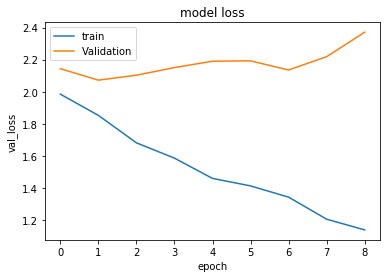

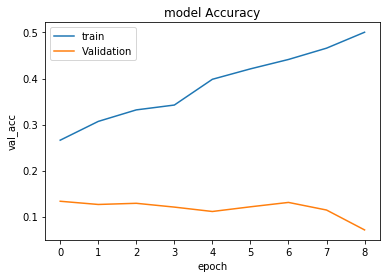

Loading Best Model
2.025051407441512
Train on 6276 samples, validate on 1572 samples
Epoch 1/10
6276/6276 [==============================] - 5s 738us/step - loss: 2.4456 - acc: 0.2177 - val_loss: 2.2334 - val_acc: 0.1934
Epoch 2/10
6276/6276 [==============================] - 4s 608us/step - loss: 2.0313 - acc: 0.2661 - val_loss: 2.0949 - val_acc: 0.2901
Epoch 3/10
6276/6276 [==============================] - 4s 629us/step - loss: 1.8335 - acc: 0.2917 - val_loss: 2.0777 - val_acc: 0.2207
Epoch 4/10
6276/6276 [==============================] - 4s 612us/step - loss: 1.6915 - acc: 0.3083 - val_loss: 2.0666 - val_acc: 0.2220
Epoch 5/10
6276/6276 [==============================] - 4s 611us/step - loss: 1.6208 - acc: 0.3395 - val_loss: 2.0759 - val_acc: 0.2074
Epoch 6/10
6276/6276 [==============================] - 4s 616us/step - loss: 1.5167 - acc: 0.3617 - val_loss: 2.0930 - val_acc: 0.2067
Epoch 7/10
6276/6276 [==============================] - 4s 638us/step - loss: 1.4010 - acc: 0.4098 

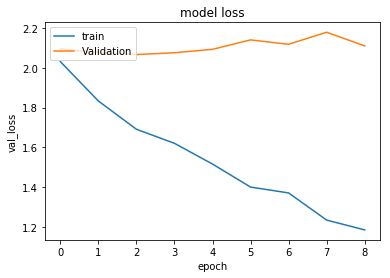

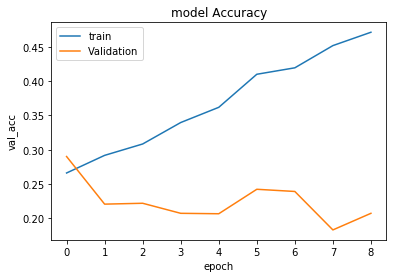

Loading Best Model
2.025523324998966
Train on 6277 samples, validate on 1571 samples
Epoch 1/10
6277/6277 [==============================] - 5s 748us/step - loss: 2.4220 - acc: 0.1848 - val_loss: 2.3007 - val_acc: 0.1731
Epoch 2/10
6277/6277 [==============================] - 4s 605us/step - loss: 2.0076 - acc: 0.2568 - val_loss: 2.1807 - val_acc: 0.1369
Epoch 3/10
6277/6277 [==============================] - 4s 612us/step - loss: 1.8193 - acc: 0.2692 - val_loss: 2.2269 - val_acc: 0.1235
Epoch 4/10
6277/6277 [==============================] - 4s 614us/step - loss: 1.6567 - acc: 0.3221 - val_loss: 2.2190 - val_acc: 0.1152
Epoch 5/10
6277/6277 [==============================] - 4s 614us/step - loss: 1.5345 - acc: 0.3331 - val_loss: 2.2500 - val_acc: 0.1095
Epoch 6/10
6277/6277 [==============================] - 4s 633us/step - loss: 1.4223 - acc: 0.3788 - val_loss: 2.3150 - val_acc: 0.0961
Epoch 7/10
6277/6277 [==============================] - 4s 615us/step - loss: 1.3208 - acc: 0.4112 

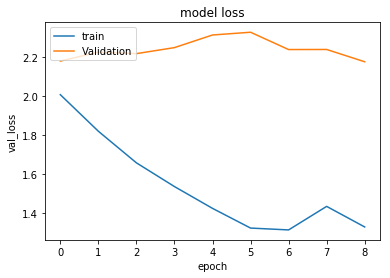

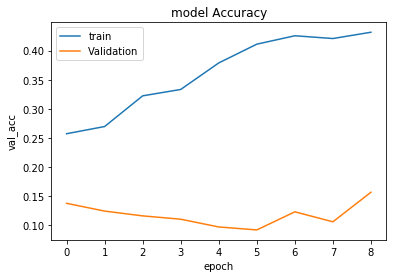

Loading Best Model
2.0593798094174645
Train on 6281 samples, validate on 1567 samples
Epoch 1/10
2560/6281 [===========>..................] - ETA: 3s - loss: 2.9712 - acc: 0.2266

In [ ]:
epochs = 10
y_count = Counter(target_map)
wtable = np.zeros((len(classes),))
for i in range(len(classes)):
    wtable[i] = y_count[i] / target_map.shape[0]

y_map = target_map
y_categorical = Y
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
start = time.time()
clfs = []
oof_preds = np.zeros((len(X_train), len(classes)))

model_file = "model.weigths"

for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    checkPoint = ModelCheckpoint(model_file, monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)

    x_train, y_train = X_train[trn_], Y[trn_]
    x_valid, y_valid = X_train[val_], Y[val_]
    
    model = build_model()    
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    stopping = EarlyStopping(monitor='val_loss', patience=60, verbose=0, mode='auto')

    model.compile(loss=mywloss, optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                        batch_size=batch_size,
                    shuffle=False,verbose=1,callbacks=[checkPoint, stopping])           
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights(model_file)
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict(x_valid,batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict(x_valid,batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(Y,oof_preds))

elapsed_time = time.time() - start
print("elapsed_time:", elapsed_time)